In [11]:
import csv
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import MONDAY, TU, WE, TH, FR, SA, SU
from IPython import display
import math
import matplotlib.ticker as mticker

%matplotlib inline

sns.set(style="whitegrid")
# sns.set_palette("Paired")
data = pd.read_csv("output.csv", header=0, index_col=0, 
                   usecols=["adj_timestamp", "mgdl", "mmol", "AfterMeal", "BeforeMeal"],
                  )
for measure in ["mmol", "mgdl", "AfterMeal", "BeforeMeal"]:
    data[measure] = pd.to_numeric(data[measure])
    data[measure].fillna(0,inplace=True)

def getMealTime(x):
    if(x["AfterMeal"] == 1):
        return "AfterMeal"
    elif(x["BeforeMeal"] == 1):
        return "BeforeMeal"
    else:
        return "None"
data["MealTime"] = data.apply(lambda x: getMealTime(x), axis=1)

data.index = pd.to_datetime(data.index)
METRIC = "mgdl"
LOW_BG = 80 #4
HIGH_BG = 130
display.display("Considering [%d - %d] mgdl ([%.1f - %.1f] mmol) as normal range" % (LOW_BG, HIGH_BG, LOW_BG/18.0, HIGH_BG/18.0))

if METRIC == "mmol":
    LOW_BG /= 18.0
    HIGH_BG /= 18.0

NUM_MONTHS = 2
first = datetime.datetime.today().replace(day=1, hour=0,minute=0,second=0,microsecond=0)
firstMonth = first - pd.offsets.MonthBegin(NUM_MONTHS)

data.head()

'Considering [80 - 130] mgdl ([4.4 - 7.2] mmol) as normal range'

mmol   mgdl  BeforeMeal  AfterMeal MealTime
adj_timestamp                                                   
2018-02-01 00:45:00   4.8   86.4          -2         -2     None
2018-02-01 08:47:00   6.4  115.2          -2         -2     None
2018-02-01 12:04:00   5.8  104.4          -2         -2     None
2018-02-01 15:35:00   5.9  106.2          -2         -2     None
2018-02-01 18:13:00  10.7  192.6          -2         -2     None

# All-Time Review

Text(0,0.5,'mmol')

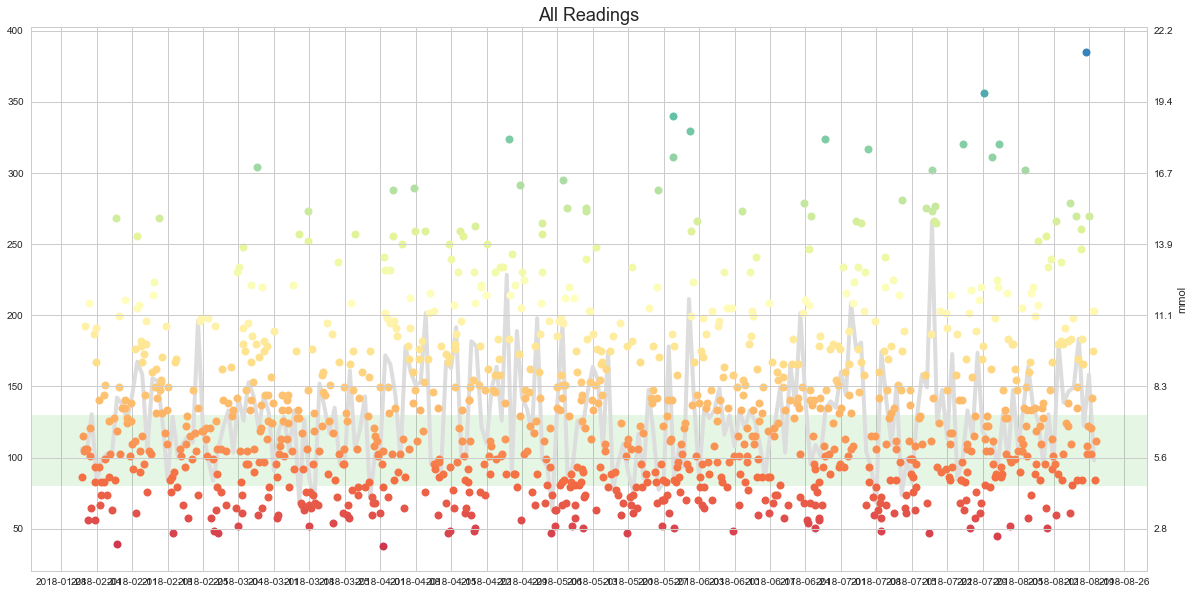

In [7]:
df = data.copy()

fig, ax = plt.subplots(1,1,figsize=(20,10))

minimum = 0
maximum = data["mgdl"].max() * 1.1
if METRIC == "mmol":
    minimum = minimum/18.0
    maximum = maximum/18.0

norm = plt.Normalize(vmin=minimum, vmax=maximum)
cmap = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)

x = df.index
y = df[METRIC]
for i, (x_val, y_val) in enumerate(zip(x,y)):
    ax.plot(x_val, y_val, marker="o", markersize=8, color=cmap.to_rgba(y_val), zorder=3)
ax.axhspan(LOW_BG, HIGH_BG, facecolor='#00AA00', alpha=0.1, zorder=1)

avg = df.resample(rule="D")[METRIC].median()
ax.plot(avg.index.values, avg, color="#DDDDDD", label="Daily Median",zorder=2, linewidth=4)
weeksFmt = mdates.DateFormatter('%Y-%m-%d')
loc = mdates.WeekdayLocator(byweekday=SU)


# format the ticks
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(weeksFmt)
ax.set_title("All Readings", size=18)

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
formatter = mticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/18.0))
ax2.yaxis.set_major_formatter(formatter)
ax2.set_ylabel("mmol")


# fig.autofmt_xdate()


In [8]:
display.display(data.describe(percentiles=[.1,.25,.5,.75,.9,.99]))

mmol         mgdl   BeforeMeal    AfterMeal
count  1057.000000  1057.000000  1057.000000  1057.000000
mean      7.538789   135.698202    -1.157994    -1.081362
std       3.314335    59.658039     0.993642     1.111665
min       2.100000    37.800000    -2.000000    -2.000000
10%       3.800000    68.400000    -2.000000    -2.000000
25%       4.900000    88.200000    -2.000000    -2.000000
50%       7.000000   126.000000    -2.000000    -2.000000
75%       9.600000   172.800000     0.000000     0.000000
90%      12.200000   219.600000     0.000000     0.000000
99%      17.076000   307.368000     0.000000     1.000000
max      21.400000   385.200000     1.000000     1.000000

# Monthly Breakdown

## Monthly Boxplots

In [9]:
WHIS = [1,99]#'range'

def makeBoxPlot(df, x, y, hue, hue_order, whis, ax, title):
    ax2 = ax.twinx()
    for whiskers in [[5,95]]:
        bp = sns.boxplot(data=df, x=x, y=y, hue=hue, hue_order=hue_order, whis=whiskers, ax=ax)
        for l in bp.lines:
            l.set_color("#AAAAAA")
        bp.legend().set_visible(False)
    bp = sns.boxplot(data=df, x=x, y=y, hue=hue, hue_order=hue_order, whis=whis, ax=ax)

    fig.suptitle(title)
    ax.set_ylim(bottom=0)
    ax2.set_ylim(ax.get_ylim())
    ax2.grid(False)

    formatter = mticker.FuncFormatter(lambda x, pos: '{:.1f}'.format(x/18.0))
    ax2.yaxis.set_major_formatter(formatter)
    ax2.set_ylabel("mmol")
    return bp


No handles with labels found to put in legend.


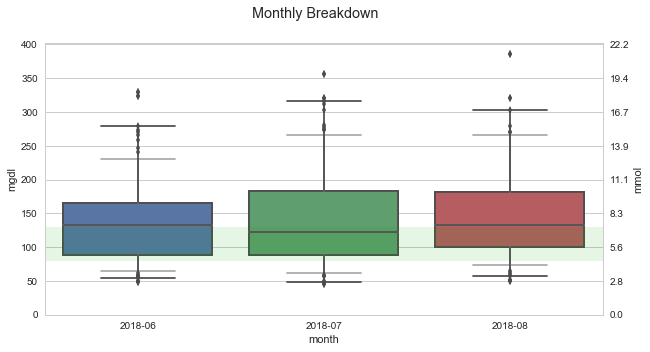

In [12]:
df = data.copy()
df = df[df.index >= firstMonth]
fig, ax = plt.subplots(1,1,figsize=(10,5))
df.reset_index(inplace=True)
df["month"] = df["adj_timestamp"].apply(lambda x: x.strftime("%Y-%m"))
ax.axhspan(LOW_BG, HIGH_BG, facecolor='#00AA00', alpha=0.1, zorder=1)
foo = makeBoxPlot(df=df, x="month", y=METRIC, hue=None, hue_order=None, whis=WHIS, ax=ax, title="Monthly Breakdown")#df.boxplot(column=METRIC, by="month", whis=WHIS,showfliers=True, sym='r.',patch_artist=True, ax=ax)


## Breakdown by Month
Typical day

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


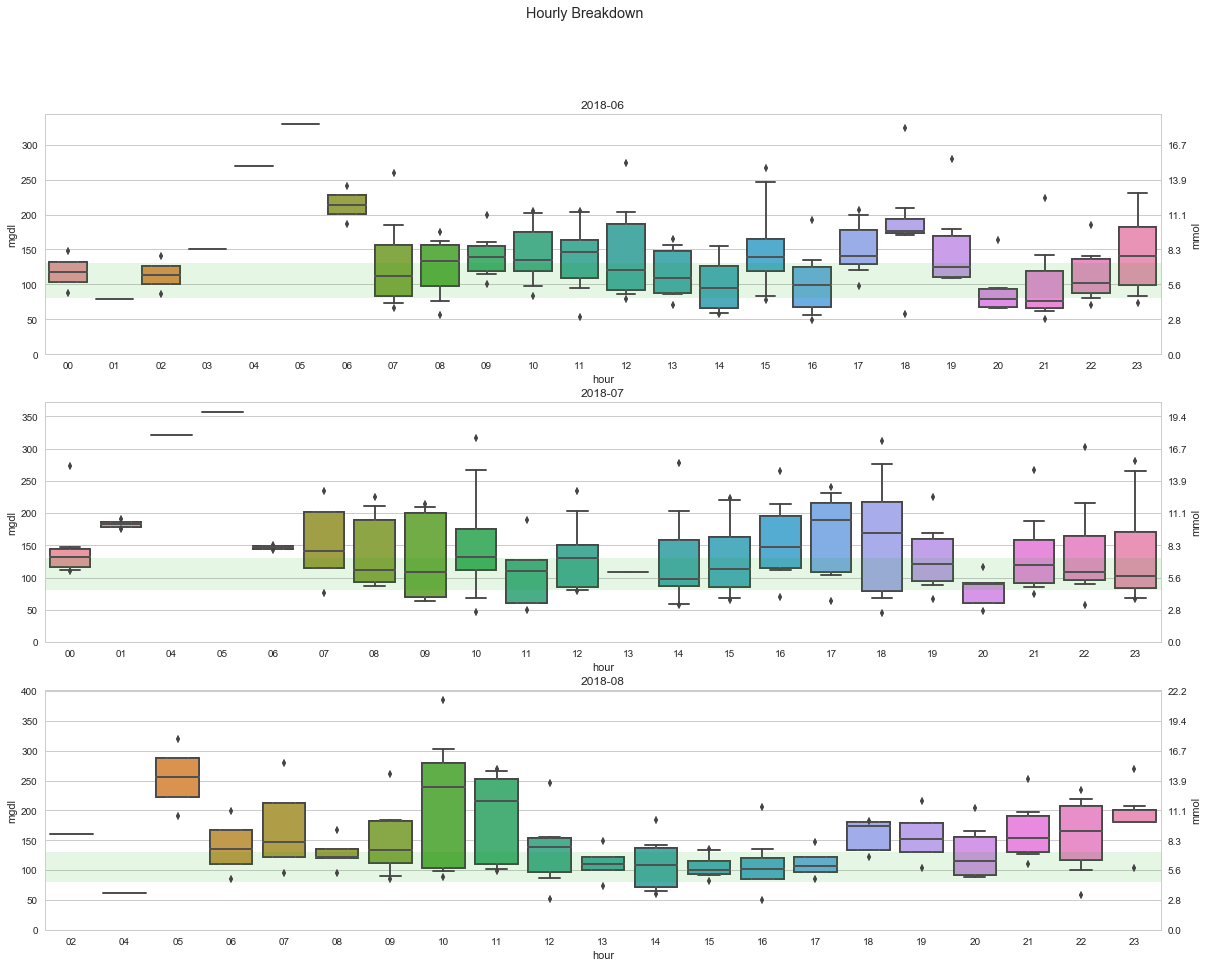

In [14]:
df = data.copy()
df = df[df.index >= firstMonth]

df.reset_index(inplace=True)
df["month"] = df["adj_timestamp"].apply(lambda x: x.strftime("%Y-%m"))
df["hour"] = df["adj_timestamp"].apply(lambda x: x.strftime("%H"))
months = df["month"].unique()
fig, axes = plt.subplots(len(months),1,figsize=(20,5*len(months)))

m = 0
for month in months:
    df_month = df[df.month == month]
    axes[m].axhspan(LOW_BG, HIGH_BG, facecolor='#00AA00', alpha=0.1, zorder=1)
    by = makeBoxPlot(df=df_month, x="hour", y=METRIC, hue=None, hue_order=None, whis=WHIS, ax=axes[m], title="Hourly Breakdown")
    axes[m].set_title(month)
    m += 1

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


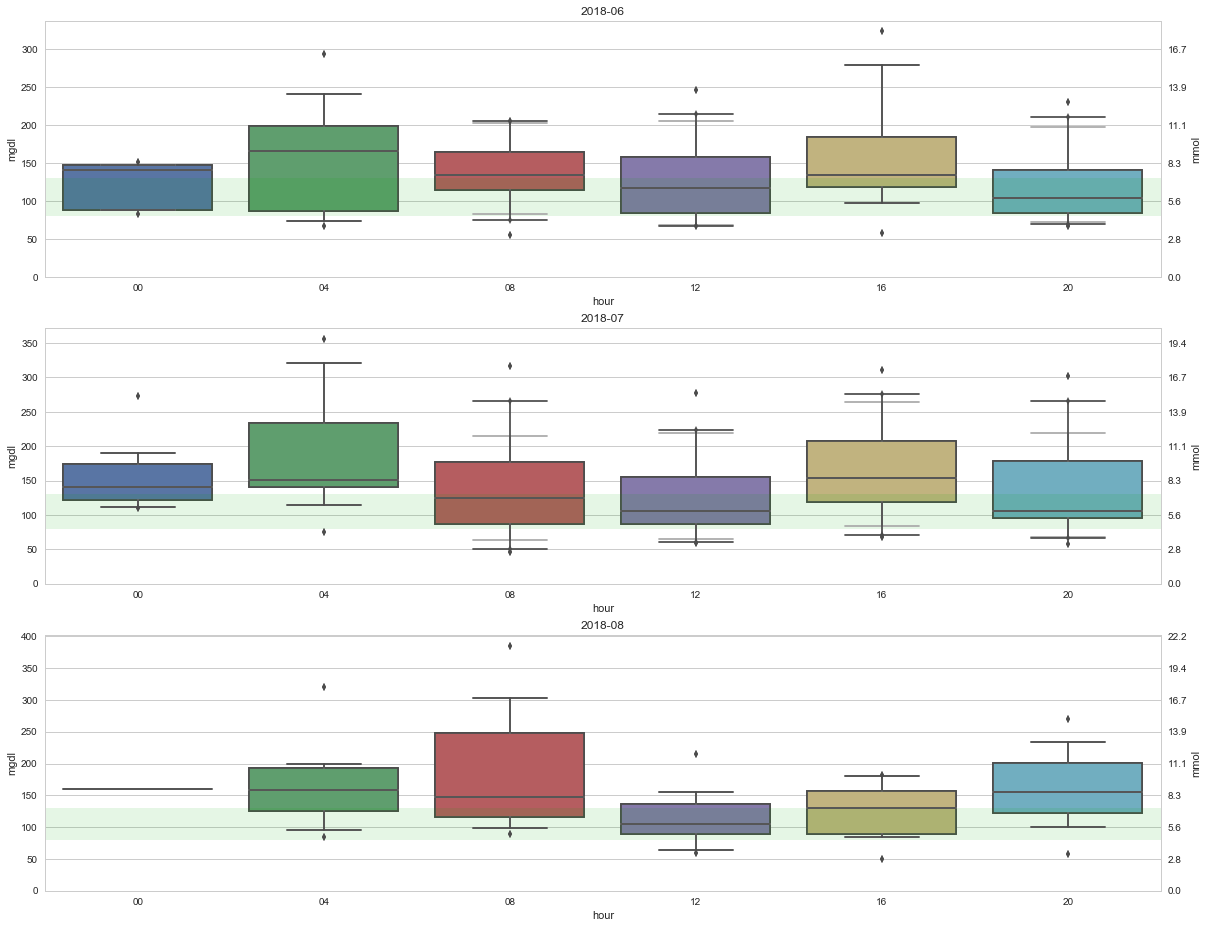

In [15]:
df = data.copy()
df = df[df.index >= firstMonth]

df = df.resample("4H").median()

df.reset_index(inplace=True)
df["month"] = df["adj_timestamp"].apply(lambda x: x.strftime("%Y-%m"))
df["hour"] = df["adj_timestamp"].apply(lambda x: x.strftime("%H"))
months = df["month"].unique()
fig, axes = plt.subplots(len(months),1,figsize=(20,16))
m = 0
for month in months:
    df_month = df[df.month == month]
    # foo = makeBoxPlot(df=df, x="month", y=METRIC, hue=None, hue_order=None, whis=WHIS, ax=ax, title="Monthly Breakdown")#df.boxplot(column=METRIC, by="month", whis=WHIS,showfliers=True, sym='r.',patch_artist=True, ax=ax)

    bp = makeBoxPlot(df=df_month, x="hour", y=METRIC, hue=None, hue_order=None, whis=WHIS, ax=axes[m], title="")
    axes[m].axhspan(LOW_BG, HIGH_BG, facecolor='#00AA00', alpha=0.1, zorder=1)

    axes[m].set_title(month)
    m += 1

# Weekend vs Weekday

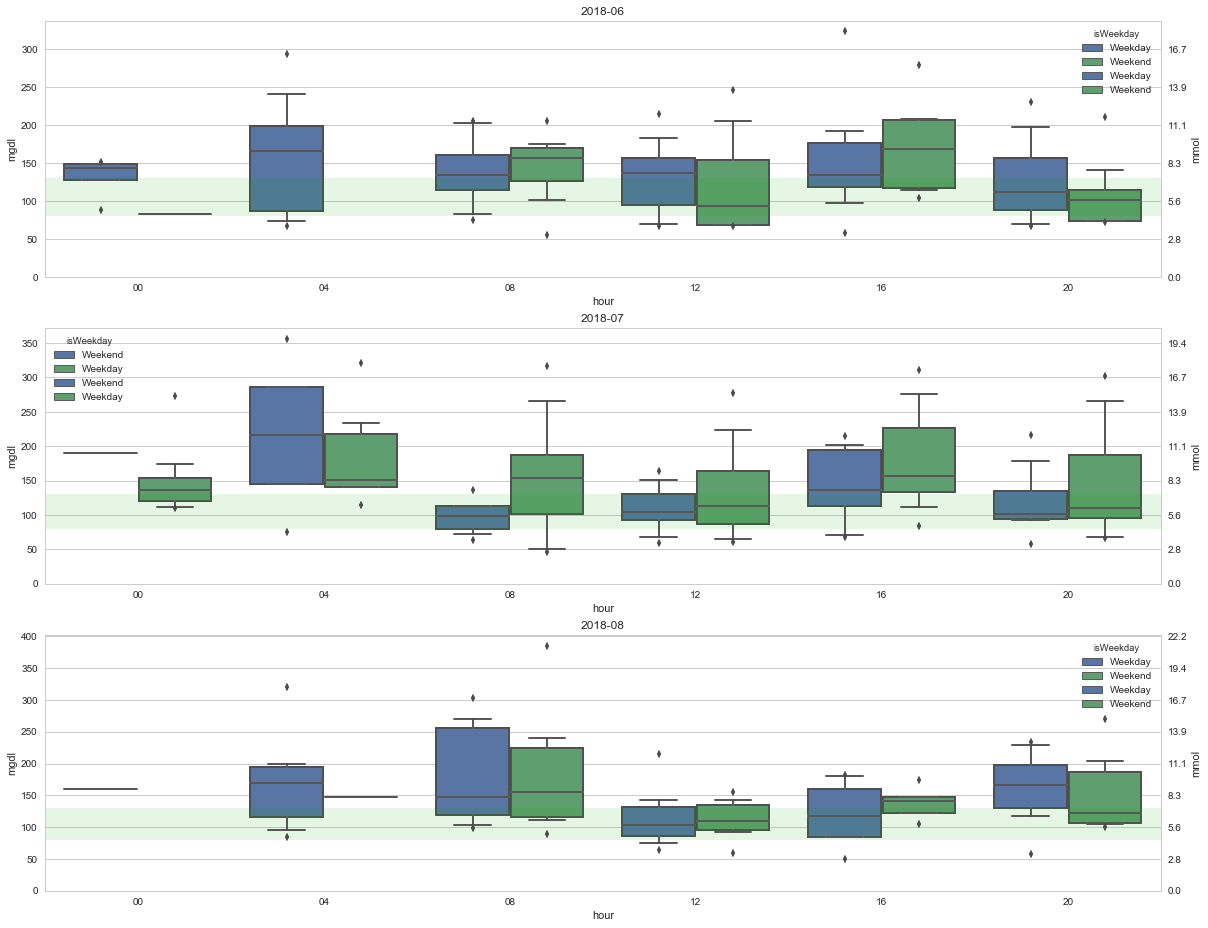

In [16]:
df = data.copy()
df = df[df.index >= firstMonth]

df = df.resample("4H").median()

def isWeekday(x):
    if x == 5 or x == 6:
        return "Weekend"
    return "Weekday"

df["isWeekday"] = df.index.dayofweek
df["isWeekday"] = df["isWeekday"].apply(isWeekday)

df.reset_index(inplace=True)
df["month"] = df["adj_timestamp"].apply(lambda x: x.strftime("%Y-%m"))
df["hour"] = df["adj_timestamp"].apply(lambda x: x.strftime("%H"))
months = df["month"].unique()
fig, axes = plt.subplots(len(months),1,figsize=(20,16))
m = 0
for month in months:
    df_month = df[df.month == month]
    bp = makeBoxPlot(df=df_month, x="hour", y=METRIC, hue="isWeekday", hue_order=None, whis=WHIS, ax=axes[m], title="")
    axes[m].axhspan(LOW_BG, HIGH_BG, facecolor='#00AA00', alpha=0.1, zorder=1)
    axes[m].set_title(month)
    m += 1